In [1]:
import pandas as pd 
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
import os
import sys

In [2]:
cwd = os.getcwd()
print(cwd)
dataPath = os.path.join(cwd, 'data')
austin_housing = pd.read_csv(os.path.join(dataPath, 'crime-housing-austin-2015.csv'))
zip_codes = pd.read_csv(os.path.join(dataPath, 'AustinZipCodes.csv'))

C:\Users\Bethany\Documents\2024-Spring\CS5830\Assn2-crime


In [3]:
austin_housing.head()
austin_housing.columns

Index(['Key', 'Council_District', 'Highest_Offense_Desc',
       'Highest_NIBRS_UCR_Offense_Description', 'Report_Date', 'Location',
       'Clearance_Status', 'Clearance_Date', 'District', 'Zip_Code_Crime',
       'Census_Tract', 'X_Coordinate', 'Y_Coordinate', 'Zip_Code_Housing',
       'Populationbelowpovertylevel', 'Medianhouseholdincome',
       'Non-WhiteNon-HispanicorLatino', 'HispanicorLatinoofanyrace',
       'Populationwithdisability', 'Unemployment',
       'Largehouseholds(5+members)',
       'Homesaffordabletopeopleearninglessthan$50000',
       'Rentalsaffordabletopeopleearninglessthan$25000',
       'Rent-restrictedunits', 'HousingChoiceVoucherholders', 'Medianrent',
       'Medianhomevalue', 'Percentageofrentalunitsinpoorcondition',
       'Percentchangeinnumberofhousingunits2000-2012',
       'Ownerunitsaffordabletoaverageretail/serviceworker',
       'Rentalunitsaffordabletoaverageretail/serviceworker',
       'Rentalunitsaffordabletoaverageartist',
       'Ownerunits

In [4]:
zip_codes.head()
zip_codes.columns

Index(['#', 'Zip Code', 'Location', 'City', 'Population', 'People / Sq. Mile',
       'National Rank'],
      dtype='object')

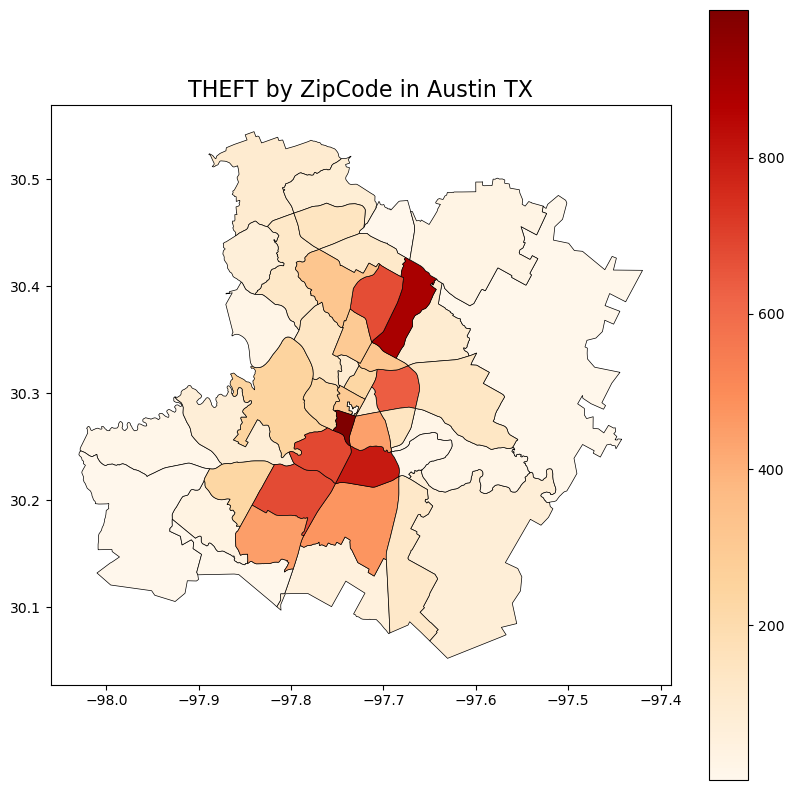

In [5]:
""" 
Karl's Analysis 
"""
import geopandas as gpd

df = austin_housing.copy()
# Date format: 01-Jan-15.  d=day, b=abbreviated month,y=2-digit year
# df['Report_Date'] = pd.to_datetime(df['Report_Date'], format='%d-%b-%y')


# Aggregate crimes by zip code
crime_zip = df[['Zip_Code_Crime', 'Highest_Offense_Desc']].copy()
crime_zip.dropna(inplace=True)
crime_zip.groupby(['Zip_Code_Crime', 'Highest_Offense_Desc']).count()
crime_zip['Total_Crime'] = crime_zip.groupby(['Zip_Code_Crime', 'Highest_Offense_Desc'])['Highest_Offense_Desc'].transform('count')
crime_zip['Zip_Code_Crime'] = crime_zip['Zip_Code_Crime'].astype('int64')
crime_zip['Zip_Code_Crime'] = crime_zip['Zip_Code_Crime'].astype('str')
# print(crime_zip.columns)
# print(crime_zip.head(5))

# Create a df with the number of THEFTS per zip code. Drop duplicates (dunno y there are duplicates)
theft_by_zip = crime_zip[crime_zip['Highest_Offense_Desc'] == 'THEFT'].copy().reset_index(drop=True)
theft_by_zip.drop(columns=['Highest_Offense_Desc'], inplace=True)
theft_by_zip.drop_duplicates(inplace=True)

""" 
Map of Austin TX  
https://openaustin.carto.com/u/oa-admin/tables/austin_area_zip_codes/public?redirected=true 
"""
# Load the GeoDataFrame
austinMap = gpd.read_file(os.path.join(dataPath, 'austin_area_zip_codes.geojson'))
austinMap['zipcode'] = austinMap['zipcode'].astype('str')

# Merge THEFT counts with austinMap
austinMap = austinMap.merge(theft_by_zip, left_on='zipcode', right_on='Zip_Code_Crime', how='left')
# Save GEOJSON file to look at data
# austinMap.to_file(os.path.join(dataPath, 'austinMap.geojson'), driver='GeoJSON')

# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
austinMap.plot(ax=ax, column='Total_Crime', cmap='OrRd', linewidth=0.5, edgecolor='black', legend=True)
ax.set_title('THEFT by ZipCode in Austin TX', fontsize=16)
plt.show()



In [8]:
""" 
Bethany's Analysis
"""
# grab crimes and dates
crime_by_date = df[['Report_Date', 'Highest_Offense_Desc']].copy()

# create month column, define order of months
crime_by_date["Month"] = crime_by_date['Report_Date'].apply(lambda x : x.split('-')[1])
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
crime_by_date["Month"] = pd.Categorical(crime_by_date['Month'], categories=month_order, ordered=True)

# groupby month and crime. Sum the total of each crime per month
crime_by_month = crime_by_date.groupby(["Month", "Highest_Offense_Desc"]).agg(Total_Reportings=('Highest_Offense_Desc', 'count')).reset_index()

# groupby month, grab the rows for the crimes with the highest total reportings that month
crime_by_month_idx = crime_by_month.groupby("Month")["Total_Reportings"].idxmax()
crime_of_the_month = crime_by_month.loc[crime_by_month_idx]

# crime_of_the_month

Text(0.5, 1.0, 'Crime of the Month')

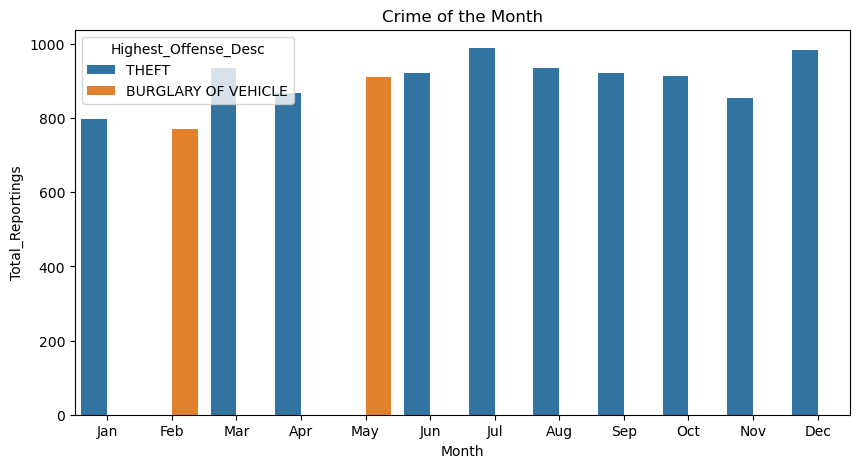

In [9]:
plt.figure(figsize=(10, 5))

sns.barplot(data=crime_of_the_month, x='Month', y='Total_Reportings', hue='Highest_Offense_Desc').set_title("Crime of the Month")

,Highest_Offense_Desc,report_counts,Medianhouseholdincome,crime_count
0,AGG ASLT ENHANC STRANGL/SUFFOC,19,11917,1
1,AGG ASLT ENHANC STRANGL/SUFFOC,19,30183,9
2,AGG ASLT ENHANC STRANGL/SUFFOC,19,33271,4
3,AGG ASLT ENHANC STRANGL/SUFFOC,19,34734,5
4,AGG ASLT ENHANC STRANGL/SUFFOC,19,35711,4
...,...,...,...,...
946,THEFT/TILL TAPPING,5,33271,1
947,THEFT/TILL TAPPING,5,39593,2
948,THEFT/TILL TAPPING,5,41056,1
949,THEFT/TILL TAPPING,5,41869,1


32

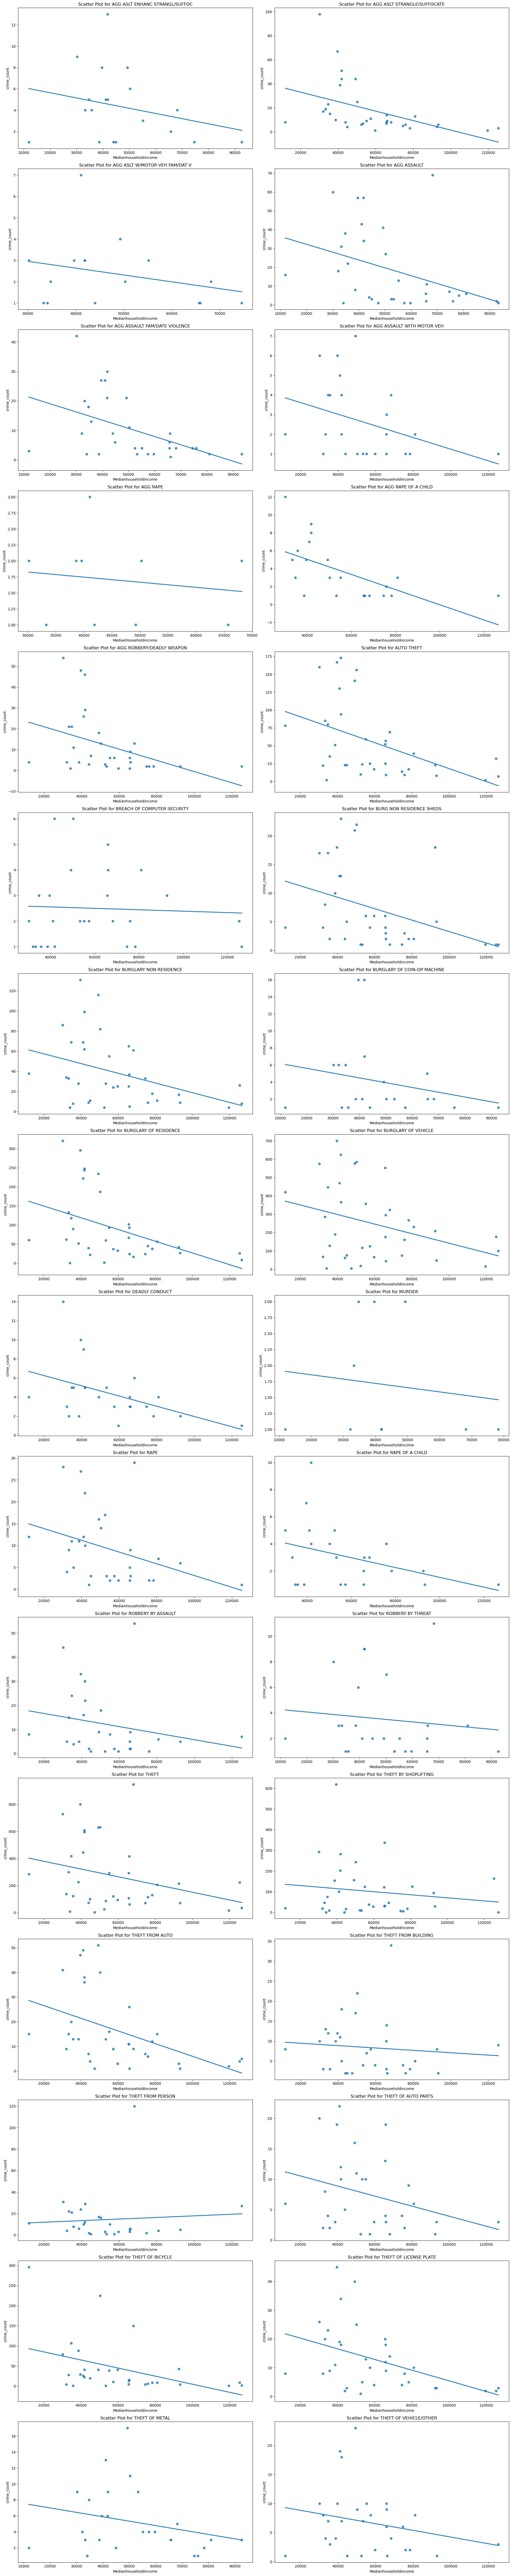

{'AGG ASLT ENHANC STRANGL/SUFFOC': PearsonRResult(statistic=-0.26302483630153295, pvalue=0.2766107692577222),
 'AGG ASLT STRANGLE/SUFFOCATE': PearsonRResult(statistic=-0.4598374316828286, pvalue=0.007094434970399344),
 'AGG ASLT W/MOTOR VEH FAM/DAT V': PearsonRResult(statistic=-0.2821421664386137, pvalue=0.2897254530303715),
 'AGG ASSAULT': PearsonRResult(statistic=-0.38626495483942935, pvalue=0.028987611165139426),
 'AGG ASSAULT FAM/DATE VIOLENCE': PearsonRResult(statistic=-0.470098109462781, pvalue=0.008758498418146401),
 'AGG ASSAULT WITH MOTOR VEH': PearsonRResult(statistic=-0.35950608966034436, pvalue=0.08445172343056097),
 'AGG RAPE': PearsonRResult(statistic=-0.15062593555968998, pvalue=0.6778801727784101),
 'AGG RAPE OF A CHILD': PearsonRResult(statistic=-0.604969263225483, pvalue=0.00285572165814382),
 'AGG ROBBERY/DEADLY WEAPON': PearsonRResult(statistic=-0.4018570997331426, pvalue=0.025031533066123882),
 'AUTO THEFT': PearsonRResult(statistic=-0.4704562950346137, pvalue=0.00

In [213]:
""" 
Bethany's Analysis
Is the type of crime correalated wtih Medianhouseholdincome? 
"""

crime_and_income = df[["Report_Date", "Highest_Offense_Desc", "Medianhouseholdincome", "Clearance_Status"]].copy()

crime_and_income = crime_and_income.dropna()

crime_and_income["Medianhouseholdincome"] = crime_and_income["Medianhouseholdincome"].apply(lambda x: int(x.replace('$','')))
crime_and_income = crime_and_income.groupby(["Highest_Offense_Desc", "Medianhouseholdincome"]).agg(crime_count=("Highest_Offense_Desc", "count")).reset_index()


report_counts = crime_and_income.groupby(["Highest_Offense_Desc"]).agg(report_counts=("Highest_Offense_Desc", "count")).reset_index()


crime_and_income = pd.merge(report_counts, crime_and_income, on="Highest_Offense_Desc")
display(crime_and_income)

fig, axes = plt.subplots(16, 2, figsize=(20, 100))
axes = axes.flatten()

crimes_over_10 = crime_and_income[crime_and_income.report_counts >= 10]["Highest_Offense_Desc"].unique()
display(len(crimes_over_10))

cor_per_crime = {}
for i, crime in enumerate(crimes_over_10):
    crime_data = crime_and_income[(crime_and_income['Highest_Offense_Desc'] == crime) & (crime_and_income['report_counts'] >=10 )]
    sns.regplot(
        data=crime_data,
        x="Medianhouseholdincome",
        y="crime_count",
#         hue="Highest_Offense_Desc",
        ax=axes[i],
        ci=None
    )
    axes[i].set_title(f'Scatter Plot for {crime}')
    cor = stats.pearsonr(crime_data.Medianhouseholdincome, crime_data.crime_count)
    cor_per_crime[crime] = cor
    
# Adjust layout
plt.tight_layout()
plt.show()

display(cor_per_crime)